# <font color=#025dfa > Bulut Türü Sınıflandırması 7 Gökyüzü Koşulunda Yer Tabanlı Bulut Görüntüleri - Cloud Type Classification Ground-Based Cloud Images into 7 Sky Conditions

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, derin öğrenme tekniklerini kullanarak yer tabanlı bulut görüntülerini yedi ayrı gökyüzü koşuluna sınıflandırmaya odaklanıyor. Görüntülerden bulut desenlerini, dokuları ve atmosferik ayrıntıları analiz ederek, model açık gökyüzü, kısmen bulutlu, kapalı ve daha fazlası gibi çeşitli bulut türlerini tanımak ve kategorize etmek üzere eğitilecektir. Doğru bulut sınıflandırması, hava durumu tahmininde, iklim çalışmalarında ve çevresel izlemede yardımcı olabilir ve bu sistemi atmosfer bilimlerindeki meteorologlar ve araştırmacılar için olmazsa olmaz bir araç haline getirir. Proje, bulut türü tanımlamasında yüksek doğruluk elde etmek için evrişimli sinir ağlarından (CNN'ler) yararlanır.

EN = This project focuses on classifying ground-based cloud images into seven distinct sky conditions using deep learning techniques. By analyzing cloud patterns, textures, and atmospheric details from images, the model will be trained to recognize and categorize various cloud types such as clear sky, partly cloudy, overcast, and more. Accurate cloud classification can aid in weather forecasting, climate studies, and environmental monitoring, making this system an essential tool for meteorologists and researchers in atmospheric sciences. The project leverages convolutional neural networks (CNNs) to achieve high accuracy in cloud type identification.

Kaynak/Source = https://www.kaggle.com/competitions/cloud-type-classification-3/overview

In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore') 
import re

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Conv2D, InputLayer , Reshape , MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv('train.csv')
image_directory = r'C:\Users\ErenK\OneDrive\Belgeler\Yapay Zeka\Proje\Computer Vision 1\bulut\images\train\\'

## <font color=#FFD700> EDA Keşif Amaçlı Veri Analizi - EDA - Exploratory Data Analysis 

In [3]:
df.head()

id  label
0  f164dae2e2cdd4e5411e93a8dc95d142.jpg      3
1  588083bc2555da85c1db7e8abd9d6922.jpg      1
2  dd20037db2aa28f7b617bbf5f6754470.jpg      2
3  a6d1c3b86279c54afd4e2fdf0b88111a.jpg      2
4  8989be70528a5ff4cfa6d098afb5722e.jpg      1

In [4]:
df.sample(5)

id  label
59   ee0351d96022afb52a510a052ea8ed9a.jpg      4
265  e03563399dddb0289e347b143e791763.jpg      3
355  bf7641e300f532cf64117f9fc359c04a.jpg      6
423  b48cc42bdf638279842f850bc9034144.jpg      0
91   9102ad3e6ed27761a537bc5c457ea5b2.jpg      6

In [5]:
df.shape

(960, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      960 non-null    object
 1   label   960 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.1+ KB


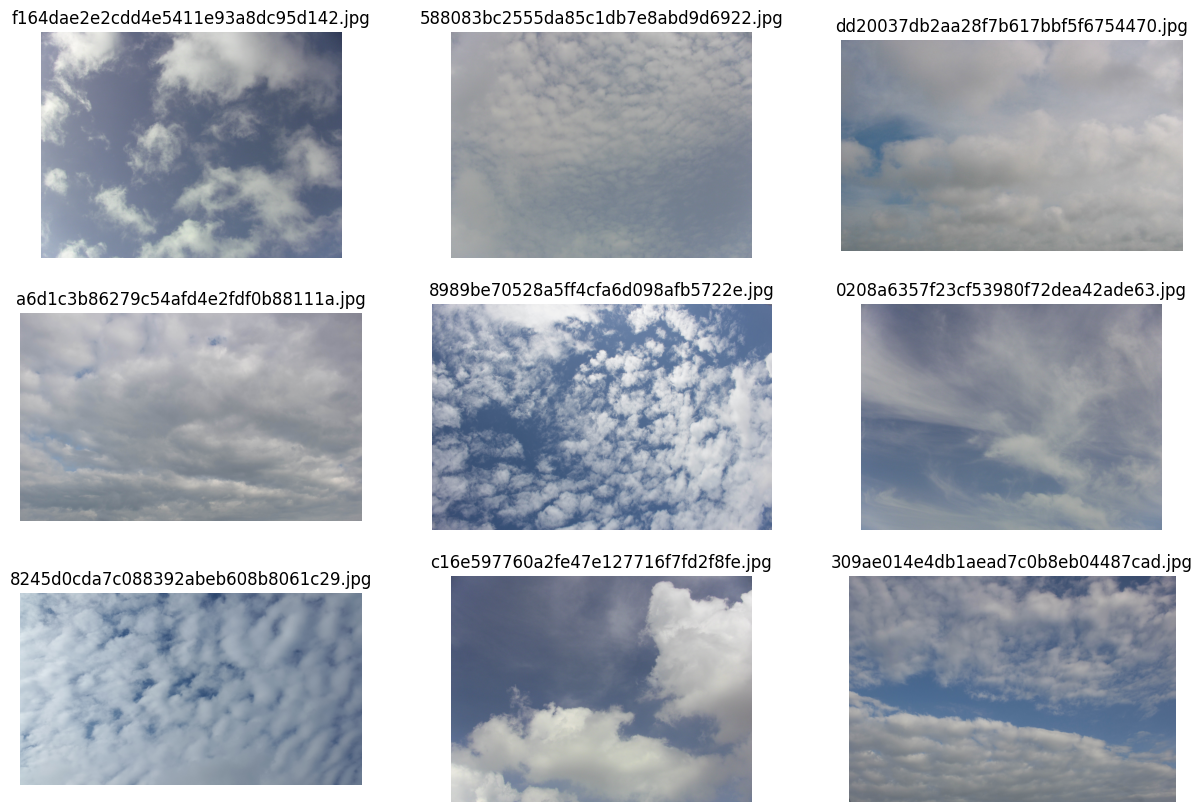

In [7]:
image_ids = df['id']  
# TR = Veri çerçevesinden resim kimliklerini alır  
# EN = Retrieves image IDs from the DataFrame

plt.figure(figsize=(15, 10))  
# TR = Şekil boyutunu ayarlar  
# EN = Sets the figure size

for i, image_id in enumerate(image_ids[:9]):  
    # TR = İlk 9 resim için döngü başlatır  
    # EN = Starts a loop for the first 9 images
    
    img = mpimg.imread(image_directory + image_id)
    # TR = Resmi dosyasından okur  
    # EN = Reads the image from the file
    
    plt.subplot(3, 3, i + 1)
    # TR = 3 satır ve 3 sütunlu bir düzen oluşturur  
    # EN = Creates a 3-row and 3-column layout
    
    plt.imshow(img)
    # TR = Resmi gösterir  
    # EN = Displays the image
    
    plt.axis('off')
    # TR = Eksenleri gizler  
    # EN = Hides the axes
    
    plt.title(image_id)
    # TR = Resim başlığını belirler  
    # EN = Sets the title for the image

In [8]:
x = []  
# TR = Resimleri depolamak için boş bir liste oluşturur  
# EN = Creates an empty list to store images

size = 64  # TR = Resimlerin boyutunu belirler  
# EN = Sets the size for the images

for img_name in df['id']:  
    # TR = Veri çerçevesindeki her resim adı için döngü başlatır  
    # EN = Starts a loop for each image name in the DataFrame
    
    img = cv2.imread(image_directory + str(img_name)) 
    # TR = Resmi dosyasından okur  
    # EN = Reads the image from the file
    
    if img is not None:  
        # TR = Eğer resim başarıyla yüklendiyse  
        # EN = If the image was loaded successfully
        
        img = cv2.resize(img, (size, size))
        # TR = Resmi belirtilen boyuta yeniden boyutlandırır  
        # EN = Resizes the image to the specified size
        
        img = img / 255.0
        # TR = Pixel values are normalized between 0 and 1  
        # EN = Normalizes the pixel values to be between 0 and 1

        x.append(img)  
        # TR = Processed image is added to the list  
        # EN = Adds the processed image to the list
    else:  
        print(f"Görüntü yüklenirken hata oluştu: {img_name}")  
        # TR = Hata mesajı yazdırır  
        # EN = Prints an error message if the image fails to load


In [9]:
x=np.array(x)
# TR = Yazıyı resim olarak okuyor bu yüzden diziye çevirdik.
# EN = The text is read as an image, so we converted it to an array

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling 

In [10]:
y = df['label'].values

In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=42)
# TR = modelimizi eğittik. 
# EN = We trained our model.

In [12]:
model = Sequential()
# TR = Ardışık bir model oluşturur, katmanlar sıralı olarak eklenir.
# EN = Creates a sequential model where layers are added in a linear stack.

model.add(InputLayer(input_shape=(size,size,3)))
# TR = Modelin giriş katmanını tanımlar ve veri boyutunu belirtir, bu durumda her görüntü sizexsize pikseldir.
# EN = Defines the input layer of the model and specifies the data dimensions, in this case, each image is sizexsize pixels.

model.add(Reshape(target_shape=(size,size,3)))
# TR = Veriyi sizexsizex1 şeklinde yeniden düzenler, gri tonlama görüntüleri için tek bir renk kanalını belirtir.
# EN = Reshapes the data to sizexsizex1, specifying a single color channel for grayscale images.

model.add(Conv2D(filters=12, kernel_size=(3,3), activation='relu'))
# TR = Konvolüsyon işlemi ile özellikleri çıkarır, filtreler görüntüdeki desenleri öğrenir ve 'relu' aktivasyon fonksiyonu ile doğrusal olmayan ilişkileri modellemesini sağlar.
# EN = Extracts features via convolution, where filters learn patterns in the image and the 'relu' activation function introduces non-linearity.

model.add(MaxPooling2D(pool_size=(2,2)))
# TR = Özellik haritasını küçültür ve en belirgin özellikleri seçer, böylece hesaplama maliyeti azalır ve modelin genelleştirme yeteneği artar.
# EN = Reduces the feature map size and selects the most prominent features, reducing computation and improving the model’s ability to generalize.

model.add(Flatten())
# TR = Çok boyutlu veri kümesini tek boyutlu bir vektöre dönüştürür, tam bağlantılı katmanlarla işlem için uygun hale getirir.
# EN = Converts the multi-dimensional feature map into a one-dimensional vector to be processed by fully connected layers.

model.add(Dense(7, activation='softmax'))
# TR = Sonuçları 7 farklı sınıfa dönüştüren bir tam bağlantılı katman ekler, bu da modelin sınıflandırma yapmasını sağlar.
# EN = Adds a fully connected layer with 7 units to output results for 7 different classes, enabling classification.

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# TR = Modeli 'adam' optimizasyonu ile derler, bu optimizasyon algoritması öğrenmeyi iyileştirir, ve 'SparseCategoricalCrossentropy' kayıp fonksiyonunu kullanarak çok sınıflı sınıflandırma yapar, doğruluk metriğiyle model performansını değerlendirir.
# EN = Compiles the model with the 'adam' optimizer, which improves learning, uses 'SparseCategoricalCrossentropy' loss function for multi-class classification, and evaluates performance with accuracy metric.

model.fit(x_train, y_train, validation_split=.10, epochs=20)
# TR = Modeli eğitim verileri (x_train) ve etiketleri (y_train) ile eğitir, %10'luk bir doğrulama seti kullanır ve 10 dönem boyunca eğitir.
# EN = Trains the model with the training data (x_train) and labels (y_train), uses 10% of the data for validation, and trains for 10 epochs.

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2149 - loss: 2.0488 - val_accuracy: 0.3506 - val_loss: 1.6116
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4319 - loss: 1.4558 - val_accuracy: 0.4416 - val_loss: 1.4455
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4381 - loss: 1.3413 - val_accuracy: 0.3117 - val_loss: 1.4275
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5045 - loss: 1.2071 - val_accuracy: 0.4026 - val_loss: 1.2389
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5951 - loss: 1.1199 - val_accuracy: 0.4935 - val_loss: 1.1794
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6055 - loss: 1.0510 - val_accuracy: 0.4805 - val_loss: 1.2150
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5786 - loss: 1.0484 - val_accuracy: 0.5455 - val_loss: 1.0775
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6811 - loss: 0.9205 - val_accuracy: 0.5325 - val_los

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 12)          │             336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 12)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 11532)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │          80,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 243,203 (950.02 KB)

 Trainable params: 81,067 (316.67 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 162,136 (633.35 KB)

In [14]:
loss, _accuracy = model.evaluate(x_test, y_test)
# TR = Test verileri (test_images) ve etiketleri (test_labels) ile modelin performansını değerlendirir, kayıp ve doğruluk değerlerini döndürür.
# EN = Evaluates the model's performance using test data (test_images) and labels (test_labels), returning loss and accuracy values.

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6399 - loss: 0.8847 


In [15]:
model.save('Bulut_CNN_model.keras')